# "PBDR" point design freeze
March/April 2023



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import yaml
import toml

# Make inline plots in this notebook, make them reasonable sizes, and with legible font size
%matplotlib inline
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = [12, 8]

#sys.path   #use for debugging

In [2]:
# List what yaml files you have so you can choose one for the next line.
!ls yamls 

splatyaml = 'yamls/SPLAT_20230409.yaml'
chlatyaml = 'yamls/CHLAT_20230409.yaml'
satyaml =   'yamls/SAT_20230409.yaml'

CHLAT_20230409.yaml SAT_20230409.yaml   SPLAT_20230409.yaml old


In [3]:
# Check to see that things work
%run ../RunOnce.py yamls/SAT_20230409.yaml

20230409 : SAT  
                             LF_1       LF_2     MF_1_1     MF_2_1     MF_1_2     MF_2_2       HF_1       HF_2
        det_bandcenter :    24.745     36.495     85.000     95.000    144.995    155.000    226.995    285.495  
         det_bandwidth :     6.490     16.990     20.400     22.800     31.890     34.100     57.990     58.990  
        sys_bandcenter :    24.742     36.476     84.972     94.965    144.927    154.922    226.769    285.262  
         sys_bandwidth :     6.473     16.874     20.234     22.592     31.484     33.636     56.658     57.611  
        sky_bandcenter :    24.741     36.382     85.103     94.975    144.978    154.892    226.632    285.031  
         sky_bandwidth :     6.464     16.496     20.070     22.663     31.676     33.627     56.342     56.202  
optics_effic_total_avg :     0.725      0.770      0.670      0.680      0.700      0.681      0.617      0.579  
        inst_effic_avg :     0.471      0.500      0.436      0.442      0

# Compare logistic and flat band P_optical for every telescope, every band.
(We need to decide whether the logistic bands are reasonable to proceed with)

We'll compare the detector bandwidth and the P_optical.  First, set the logistic parameters such that the 
logistic bands are very "square" to see that the results are nearly identical to the flat band calculation, 
then adjust those parameters to "more realistic" values and rerun to see how big the shifts are.

In [4]:
# these logistic parameter values seem to give reasonable "knees" by eye when compared 
# with Jeff McMahon's simulated module bands, for most of the band edges.

# Very square logistic bands:
#logistic_a = 20.0
#logistic_n = 0.3

# More realistic logistic bands:
logistic_a = 2.0
logistic_n = 0.7

yamlfiles = [chlatyaml, splatyaml, satyaml]

for yamlfile in yamlfiles:
    Popts = {} # optical powers
    bw = {}    # bandwidths
    NETs = {}  # NETs
    print('\n-----------------')
    print(yamlfile)
    for band_method in ['flat','logistic']:
        Popts[band_method]={}
        bw[band_method]={}
        NETs[band_method]={}
        
        if 'channels' in sim:
            sim.clear()
        sim = yaml.safe_load(open(yamlfile))
    
        # yamls are correct for flat bands.
        # Adjust parameters to suit logistic band calculation if we're doing that.
        if band_method == 'logistic':
            for ch in sim['channels'].keys():
                _nuL = sim['channels'][ch]['nu_low']
                _nuH = sim['channels'][ch]['nu_high']
                sim['channels'][ch]['band_response']['method']='logistic'
                sim['channels'][ch]['band_response']['nu_lowedge'] = _nuL
                sim['channels'][ch]['band_response']['nu_highedge'] = _nuH
                sim['channels'][ch]['nu_low'] = 0.6*_nuL
                sim['channels'][ch]['nu_high'] = 1.4*_nuH
                sim['channels'][ch]['band_response']['a']=logistic_a
                sim['channels'][ch]['band_response']['n']=logistic_n

        run_optics(sim)
        run_bolos(sim)
        
        for ch in sim['channels'].keys():
            Popts[band_method][ch]=1e12*sim['outputs'][ch]['P_opt']
            bw[band_method][ch]=1e-9*sim['outputs'][ch]['det_bandwidth']
            NETs[band_method][ch]=1e6*sim['outputs'][ch]['NET_NC_total']

    print('P_opt          Flat       Logistic   Flat/Logistic')
    for ch in sim['channels'].keys():
        print('{0:9s}  {1:9.3f}  {2:9.3f}  {3:9.3f}'.format(ch, Popts['flat'][ch], Popts['logistic'][ch], Popts['flat'][ch]/Popts['logistic'][ch]))
 
    print()
    
    print('Det_Bandwidth  Flat       Logistic   Flat/Logistic')
    for ch in sim['channels'].keys():
        print('{0:9s}  {1:9.3f}  {2:9.3f}  {3:9.3f}'.format(ch, bw['flat'][ch], bw['logistic'][ch], bw['flat'][ch]/bw['logistic'][ch]))

    print()
    
    print('NET_cmb        Flat       Logistic   Flat/Logistic')
    for ch in sim['channels'].keys():
        print('{0:9s}  {1:9.3f}  {2:9.3f}  {3:9.3f}'.format(ch, NETs['flat'][ch], NETs['logistic'][ch], NETs['flat'][ch]/NETs['logistic'][ch]))

    


-----------------
yamls/CHLAT_20230409.yaml
P_opt          Flat       Logistic   Flat/Logistic
ULF            0.158      0.161      0.983
LF_1           0.190      0.192      0.993
LF_2           1.020      1.036      0.984
MF_1           1.375      1.395      0.986
MF_2           4.160      4.289      0.970
HF_1          11.967     12.067      0.992
HF_2          17.422     18.118      0.962

Det_Bandwidth  Flat       Logistic   Flat/Logistic
ULF            4.990      5.067      0.985
LF_1           6.490      6.548      0.991
LF_2          16.990     17.000      0.999
MF_1          28.990     29.003      1.000
MF_2          40.990     41.003      1.000
HF_1          57.990     58.003      1.000
HF_2          58.990     59.012      1.000

NET_cmb        Flat       Logistic   Flat/Logistic
ULF          429.690    408.572      1.052
LF_1         405.582    390.203      1.039
LF_2         241.883    235.194      1.028
MF_1         303.447    299.707      1.012
MF_2         334.290    33

# Discussion of flat vs logistic results

This is reassuring.   When the logistic band parameters are set to be "very square", most differences between flat and logistic are << 1%, with only one value (for ULF NETs) changing by (just a bit) more than 1%.

Moving to "more realistic" logistic band parameters, we actually see an improvement in NET by generally a couple percent.  I suspect that this is because the correlated (Bose) term in the photon noise favors adding more frequencies at reduced optical efficiency, ie you do better with double the bandwidth at half the efficiency.  The most important sanity-check here is that things are pretty stable.

So, I think it's okay to go ahead and use flat band parameters, since the Popt's are very similar, and the NET is a little conservative (higher than logistic).

We now proceed to find the PBDR-design results.  The first step is to find common Psats for the CHLAT and SPLAT.

# Find common Psats for the CHLAT and SPLAT
Using flat bands from yaml files.

In [5]:
Popts={'SPLAT':{},'CHLAT':{}, 'AVG':{}}
Psats={'SPLAT':{},'CHLAT':{}, 'AVG':{}}
NET_NCs = {'SPLAT':{},'CHLAT':{} }

#####--------------------------------------------------------------------------------------------------
##### Run SPLAT and CHLAT once to find Psats from actual optical power, then calculate avg of those.
# Run the SPLAT
sim = yaml.safe_load(open(splatyaml))
run_optics(sim)
run_bolos(sim)
# Save the optical powers to a numpy array
for ch in sim['outputs'].keys():
    Popts['SPLAT'][ch]=sim['outputs'][ch]['P_opt']
    Psats['SPLAT'][ch]=sim['outputs'][ch]['P_sat']
    NET_NCs['SPLAT'][ch]=sim['outputs'][ch]['NET_NC_total']  # single detector NETs

# Run the CHLAT
sim.clear()
sim = yaml.safe_load(open(chlatyaml))
run_optics(sim)
run_bolos(sim)
# Save the optical powers to a numpy array
for ch in sim['outputs'].keys():
    Popts['CHLAT'][ch]=sim['outputs'][ch]['P_opt']
    Psats['CHLAT'][ch]=sim['outputs'][ch]['P_sat']
    NET_NCs['CHLAT'][ch]=sim['outputs'][ch]['NET_NC_total']  # single detector NETs
    Popts['AVG'][ch] = (Popts['CHLAT'][ch] + Popts['SPLAT'][ch])/2
    Psats['AVG'][ch] = (Psats['CHLAT'][ch] + Psats['SPLAT'][ch])/2

print('P_opticals in pW')
print('         SPLAT   CHLAT    AVG')
for ch in sim['outputs'].keys():
    print('{0:5s}: {1:7.3f} {2:7.3f}  {3:7.3f}'.format(ch, 1e12*Popts['SPLAT'][ch], 1e12*Popts['CHLAT'][ch], 1e12*Popts['AVG'][ch]))

print()
print('P_sats in pW')
print('         SPLAT   CHLAT    AVG')
for ch in sim['outputs'].keys():
    print('{0:5s}: {1:7.3f} {2:7.3f}  {3:7.3f}'.format(ch, 1e12*Psats['SPLAT'][ch], 1e12*Psats['CHLAT'][ch], 1e12*Psats['AVG'][ch]))

print()
print('NET_NCs - with bespoke Psats in CHLAT and SPLAT')
print('          SPLAT    CHLAT')
for ch in sim['outputs'].keys():
    print('{0:5s}: {1:8.1f} {2:8.1f}'.format(ch, 1e6*NET_NCs['SPLAT'][ch], 1e6*NET_NCs['CHLAT'][ch]))

#####--------------------------------------------------------------------------------------------------
# Now re-run with fixed Psats, set to the average, and find and print the new NETs
# Run the SPLAT
sim.clear()
sim = yaml.safe_load(open(splatyaml))
sim['bolo_config']['psat_method']='specified'
for ch in sim['channels'].keys():
    sim['channels'][ch]['psat']=Psats['AVG'][ch]
run_optics(sim)
run_bolos(sim)
# Save the optical powers to a numpy array
for ch in sim['outputs'].keys():
    Popts['SPLAT'][ch]=sim['outputs'][ch]['P_opt']
    Psats['SPLAT'][ch]=sim['outputs'][ch]['P_sat']
    NET_NCs['SPLAT'][ch]=sim['outputs'][ch]['NET_NC_total']  # single detector NETs
    
# Run the CHLAT
sim.clear()
sim = yaml.safe_load(open(chlatyaml))
sim['bolo_config']['psat_method']='specified'
for ch in sim['channels'].keys():
    sim['channels'][ch]['psat']=Psats['AVG'][ch]
run_optics(sim)
run_bolos(sim)
# Save the optical powers to a numpy array
for ch in sim['outputs'].keys():
    Popts['CHLAT'][ch]=sim['outputs'][ch]['P_opt']
    Psats['CHLAT'][ch]=sim['outputs'][ch]['P_sat']
    NET_NCs['CHLAT'][ch]=sim['outputs'][ch]['NET_NC_total']  # single detector NETs

print('\n----------------------')
print('Psats same in CHLAT and SPLAT')
print('P_sats in pW')
print('         SPLAT   CHLAT    AVG')
for ch in sim['outputs'].keys():
    print('{0:5s}: {1:7.3f} {2:7.3f}  {3:7.3f}'.format(ch, 1e12*Psats['SPLAT'][ch], 1e12*Psats['CHLAT'][ch], 1e12*Psats['AVG'][ch]))

print()
print('NET_NCs')
print('          SPLAT    CHLAT')
for ch in sim['outputs'].keys():
    print('{0:5s}: {1:8.1f} {2:8.1f}'.format(ch, 1e6*NET_NCs['SPLAT'][ch], 1e6*NET_NCs['CHLAT'][ch]))

    
#####--------------------------------------------------------------------------------------------------

    

P_opticals in pW
         SPLAT   CHLAT    AVG
ULF  :   0.114   0.158    0.136
LF_1 :   0.141   0.190    0.166
LF_2 :   0.901   1.020    0.960
MF_1 :   1.174   1.375    1.275
MF_2 :   2.965   4.160    3.562
HF_1 :   8.195  11.967   10.081
HF_2 :  11.845  17.422   14.633

P_sats in pW
         SPLAT   CHLAT    AVG
ULF  :   0.343   0.474    0.408
LF_1 :   0.423   0.571    0.497
LF_2 :   2.702   3.059    2.881
MF_1 :   3.523   4.126    3.825
MF_2 :   8.896  12.479   10.687
HF_1 :  24.584  35.902   30.243
HF_2 :  35.534  52.266   43.900

NET_NCs - with bespoke Psats in CHLAT and SPLAT
          SPLAT    CHLAT
ULF  :    398.0    429.7
LF_1 :    386.8    405.6
LF_2 :    256.7    241.9
MF_1 :    319.0    303.4
MF_2 :    290.8    334.3
HF_1 :    571.0    730.3
HF_2 :   1309.7   1787.6

----------------------
Psats same in CHLAT and SPLAT
P_sats in pW
         SPLAT   CHLAT    AVG
ULF  :   0.408   0.408    0.408
LF_1 :   0.497   0.497    0.497
LF_2 :   2.881   2.881    2.881
MF_1 :   3.825   3.

# Find and report the values we need for requirements (and other things), for each channel, each telescope.
This uses flat bands from yaml files, and the common SPLAT/CHLAT Psats from the cell above.

In [6]:
# CHLAT
#sim_chlat.clear()
sim_chlat = yaml.safe_load(open(chlatyaml))
sim_chlat['bolo_config']['psat_method']='specified'
for ch in sim_chlat['channels'].keys():
    sim_chlat['channels'][ch]['psat']=Psats['AVG'][ch]
run_optics(sim_chlat)
run_bolos(sim_chlat)
print_full_table(sim_chlat)
print_lyot_efficiencies(sim_chlat)

print('\n\n=======================================')

# SPLAT
#sim_splat.clear()
sim_splat = yaml.safe_load(open(splatyaml))
sim_splat['bolo_config']['psat_method']='specified'
for ch in sim_splat['channels'].keys():
    sim_splat['channels'][ch]['psat']=Psats['AVG'][ch]
run_optics(sim_splat)
run_bolos(sim_splat)
print_full_table(sim_splat)
print_lyot_efficiencies(sim_splat)

print('\n\n=======================================')

# SAT
#sim_sat.clear()
sim_sat = yaml.safe_load(open(satyaml))
run_optics(sim_sat)
run_bolos(sim_sat)
print_full_table(sim_sat)
print_lyot_efficiencies(sim_sat)

20230409 : CHLAT
                              ULF       LF_1       LF_2       MF_1       MF_2       HF_1       HF_2
        det_bandcenter :    19.995     24.745     36.495     91.495    148.495    226.995    285.495  
         det_bandwidth :     4.990      6.490     16.990     28.990     40.990     57.990     58.990  
        sys_bandcenter :    20.174     24.994     37.483     92.748    149.609    227.667    285.671  
         sys_bandwidth :     4.092      5.256     12.634     22.969     35.466     54.749     58.244  
        sky_bandcenter :    20.166     25.001     37.420     92.795    149.552    227.521    285.215  
         sky_bandwidth :     4.140      5.240     13.049     23.023     36.251     55.139     57.723  
optics_effic_total_avg :     0.200      0.180      0.341      0.238      0.471      0.652      0.682  
        inst_effic_avg :     0.130      0.117      0.222      0.155      0.306      0.424      0.443  
         effic_tot_avg :     0.128      0.115      0.215   

# Calculate and write out NET vs pwv.
(to a toml file)

In [7]:
pwv_vec = np.arange(0,4000,100)  # 0 microns to 4000 microns in steps of 100 microns
yamldict = {'CHLAT':chlatyaml, 'SPLAT':splatyaml, 'SAT':satyaml}
outdict = {}

for tel in yamldict.keys():
    print(tel)
    outdict[tel]={}
    outdict[tel]['ver']=yamldict[tel]
    outdict[tel]['pwv']=pwv_vec

    # Open yaml file;  if a LAT, set it to specified Psats from above.
    sim = yaml.safe_load(open(yamldict[tel]))
    outdict[tel]['elev']=sim['sources']['atmosphere']['elevation']
    if (tel=='CHLAT' or tel=='SPLAT'):
        print('Setting to fixed Psats:', tel)
        sim['bolo_config']['psat_method']='specified'
        for ch in sim['channels'].keys():
            sim['channels'][ch]['psat']=Psats['AVG'][ch]
    
    outdict[tel]['channels']={}
    for ch in sim['channels'].keys():
        outdict[tel]['channels'][ch]={'net':np.array([]),'popt':np.array([]),'corr_factor':np.array([])}
    #loop through pwv's
    for pwv in pwv_vec:
        # Set yaml's pwv
        sim['sources']['atmosphere']['pwv']= pwv
        run_optics(sim)
        run_bolos(sim)
        for ch in sim['channels'].keys():
            outdict[tel]['channels'][ch]['net'] = np.append(outdict[tel]['channels'][ch]['net'], sim['outputs'][ch]['NET_NC_total'])
            outdict[tel]['channels'][ch]['popt'] = np.append(outdict[tel]['channels'][ch]['popt'], sim['outputs'][ch]['P_opt'])
            outdict[tel]['channels'][ch]['corr_factor'] = np.append(outdict[tel]['channels'][ch]['corr_factor'], sim['outputs'][ch]['corr_factor'])

# Save toml file
with open('pwv_data.toml', "w") as toml_file:
    toml.dump(outdict, toml_file, encoder=toml.TomlNumpyEncoder())
print('\n DONE =======================================')


CHLAT
Setting to fixed Psats: CHLAT
SPLAT
Setting to fixed Psats: SPLAT
SAT

 DONE =======================================


# Calculate and write out NET vs elevation
(to a toml file)


In [8]:
elev_vec = np.arange(20,80)  # 30 deg to 80 deg
yamldict = {'CHLAT':chlatyaml, 'SPLAT':splatyaml, 'SAT':satyaml}
outdict = {}

for tel in yamldict.keys():
    print(tel)
    outdict[tel]={}
    outdict[tel]['ver']=yamldict[tel]
    outdict[tel]['elev']=elev_vec

    # Open yaml file;  if a LAT, set it to specified Psats from above.
    sim = yaml.safe_load(open(yamldict[tel]))
    outdict[tel]['pwv']=sim['sources']['atmosphere']['pwv']
    if (tel=='CHLAT' or tel=='SPLAT'):
        print('Setting to fixed Psats:', tel)
        sim['bolo_config']['psat_method']='specified'
        for ch in sim['channels'].keys():
            sim['channels'][ch]['psat']=Psats['AVG'][ch]
    
    outdict[tel]['channels']={}
    for ch in sim['channels'].keys():
        outdict[tel]['channels'][ch]={'net':np.array([]),'popt':np.array([]),'corr_factor':np.array([])}
    #loop through pwv's
    for elev in elev_vec:
        # Set yaml's pwv
        sim['sources']['atmosphere']['elevation']= elev
        run_optics(sim)
        run_bolos(sim)
        for ch in sim['channels'].keys():
            outdict[tel]['channels'][ch]['net'] = np.append(outdict[tel]['channels'][ch]['net'], sim['outputs'][ch]['NET_NC_total'])
            outdict[tel]['channels'][ch]['popt'] = np.append(outdict[tel]['channels'][ch]['popt'], sim['outputs'][ch]['P_opt'])
            outdict[tel]['channels'][ch]['corr_factor'] = np.append(outdict[tel]['channels'][ch]['corr_factor'], sim['outputs'][ch]['corr_factor'])

# Save toml file
with open('elevation_data.toml', "w") as toml_file:
    toml.dump(outdict, toml_file, encoder=toml.TomlNumpyEncoder())
print('\n DONE =======================================')

CHLAT
Setting to fixed Psats: CHLAT
SPLAT
Setting to fixed Psats: SPLAT
SAT

 DONE =======================================


# Plot the NET and Popt vs elevation
(from the toml file)

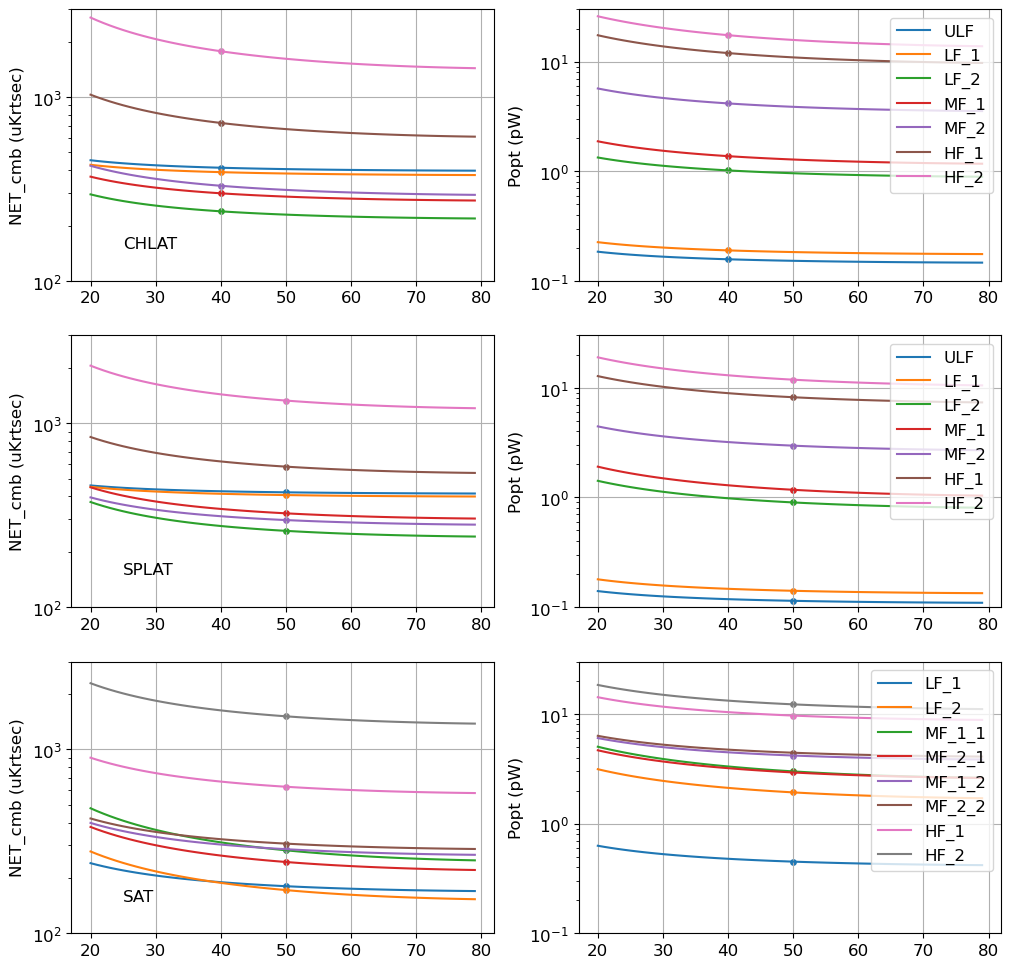

In [9]:
indata = toml.load('elevation_data.toml')

plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.figsize'] = [12,12]
sims = {'CHLAT':sim_chlat, 'SPLAT':sim_splat, 'SAT':sim_sat}

nn = 1
mm = 2
for tel in indata.keys():
    elev_vec = np.array(indata[tel]['elev'])
    
    plt.subplot(3,2,nn)
    for ch in indata[tel]['channels'].keys():
        net = 1e6*np.array(indata[tel]['channels'][ch]['net'])
        plt.semilogy(elev_vec,net,label=ch)
        # put a large dot at default value
        elev0 = sims[tel]['sources']['atmosphere']['elevation']
        net0 = 1e6*sims[tel]['outputs'][ch]['NET_NC_total']
        plt.scatter(elev0,net0,s=15,marker='o')

    plt.subplot(3,2,mm)
    for ch in indata[tel]['channels'].keys():
        popt = 1e12*np.array(indata[tel]['channels'][ch]['popt'])
        plt.semilogy(elev_vec,popt,label=ch)
        # Large dot at nominal location
        elev0 = sims[tel]['sources']['atmosphere']['elevation']
        popt0 = 1e12*sims[tel]['outputs'][ch]['P_opt']
        plt.scatter(elev0,popt0,s=15,marker='o')
    
    plt.subplot(3,2,nn)
    plt.ylim(100,3000)
    plt.ylabel('NET_cmb (uKrtsec)')
    plt.text(25,150,tel)
    #plt.legend(loc='upper right')
    plt.grid()
    
    plt.subplot(3,2,mm)
    plt.ylim(0.1,30)
    plt.ylabel('Popt (pW)')
    plt.legend(loc='upper right')
    plt.grid()
    
    nn = nn+2
    mm = mm+2

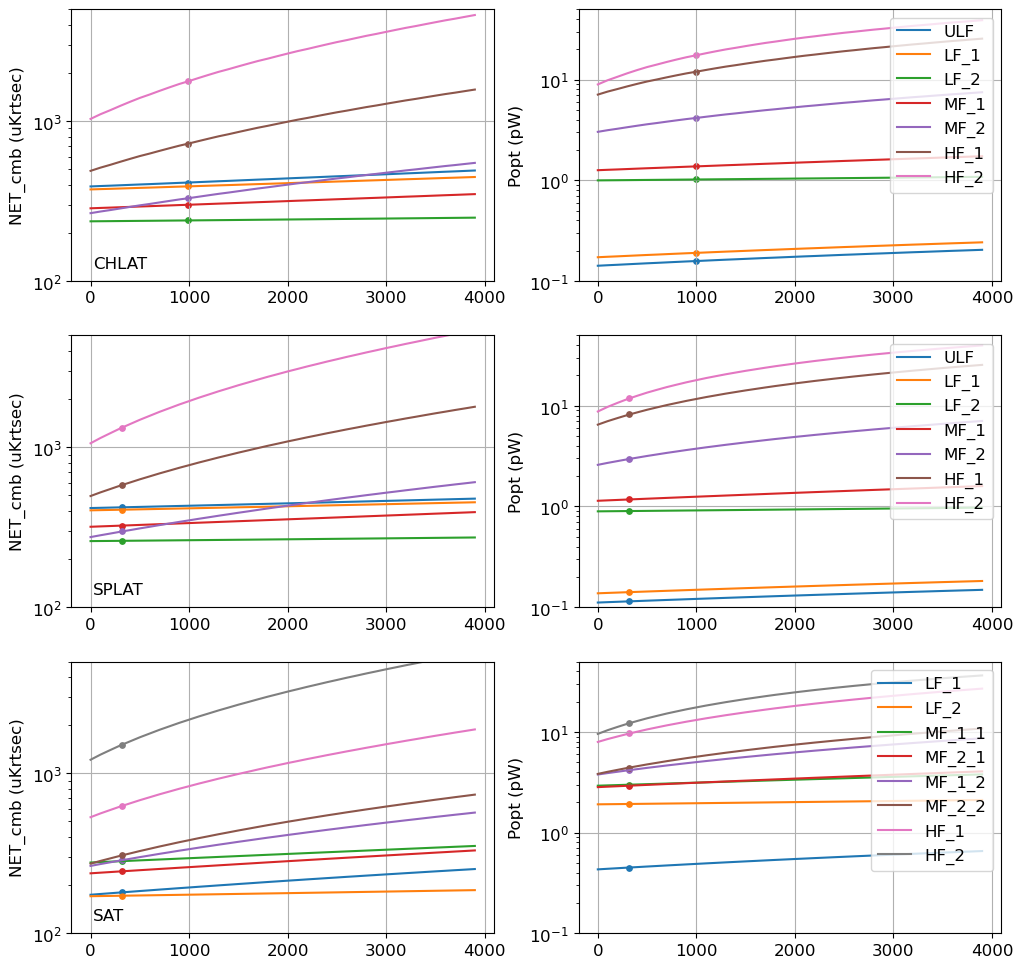

In [10]:
indata = toml.load('pwv_data.toml')

plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.figsize'] = [12,12]

nn = 1
mm = 2
for tel in indata.keys():
    x_vec = np.array(indata[tel]['pwv'])
    
    plt.subplot(3,2,nn)
    for ch in indata[tel]['channels'].keys():
        net = 1e6*np.array(indata[tel]['channels'][ch]['net'])
        plt.semilogy(x_vec,net,label=ch)
        # put a large dot at default value
        elev0 = sims[tel]['sources']['atmosphere']['pwv']
        net0 = 1e6*sims[tel]['outputs'][ch]['NET_NC_total']
        plt.scatter(elev0,net0,s=15,marker='o')

    plt.subplot(3,2,mm)
    for ch in indata[tel]['channels'].keys():
        popt = 1e12*np.array(indata[tel]['channels'][ch]['popt'])
        plt.semilogy(x_vec,popt,label=ch)
        # Large dot at nominal location
        elev0 = sims[tel]['sources']['atmosphere']['pwv']
        popt0 = 1e12*sims[tel]['outputs'][ch]['P_opt']
        plt.scatter(elev0,popt0,s=15,marker='o')
    
    plt.subplot(3,2,nn)
    plt.ylim(100,5000)
    plt.ylabel('NET_cmb (uKrtsec)')
    plt.text(25,120,tel)
    #plt.legend()
    plt.grid()
    
    plt.subplot(3,2,mm)
    plt.ylim(0.1,50)
    plt.ylabel('Popt (pW)')
    plt.legend(loc='upper right')
    plt.grid()
    
    nn = nn+2
    mm = mm+2
    
    


# Plot and report optics requirements:
optics efficiency (not module), and optics loading on detector in pW/GHz.


Flat band-average optics efficiency (0 to 1) and detector loading (pW/GHz)
----------------
CHLAT      Effic  Loading
  ULF   :  0.200  0.033
  LF_1  :  0.180  0.030
  LF_2  :  0.341  0.050
  MF_1  :  0.238  0.038
  MF_2  :  0.471  0.084
  HF_1  :  0.652  0.139
  HF_2  :  0.682  0.168
----------------
SPLAT      Effic  Loading
  ULF   :  0.173  0.023
  LF_1  :  0.156  0.021
  LF_2  :  0.301  0.034
  MF_1  :  0.207  0.026
  MF_2  :  0.424  0.061
  HF_1  :  0.617  0.111
  HF_2  :  0.665  0.144
----------------
SAT        Effic  Loading
  LF_1  :  0.725  0.050
  LF_2  :  0.770  0.061
  MF_1_1:  0.670  0.081
  MF_2_1:  0.680  0.088
  MF_1_2:  0.700  0.121
  MF_2_2:  0.681  0.123
  HF_1  :  0.617  0.151
  HF_2  :  0.579  0.175


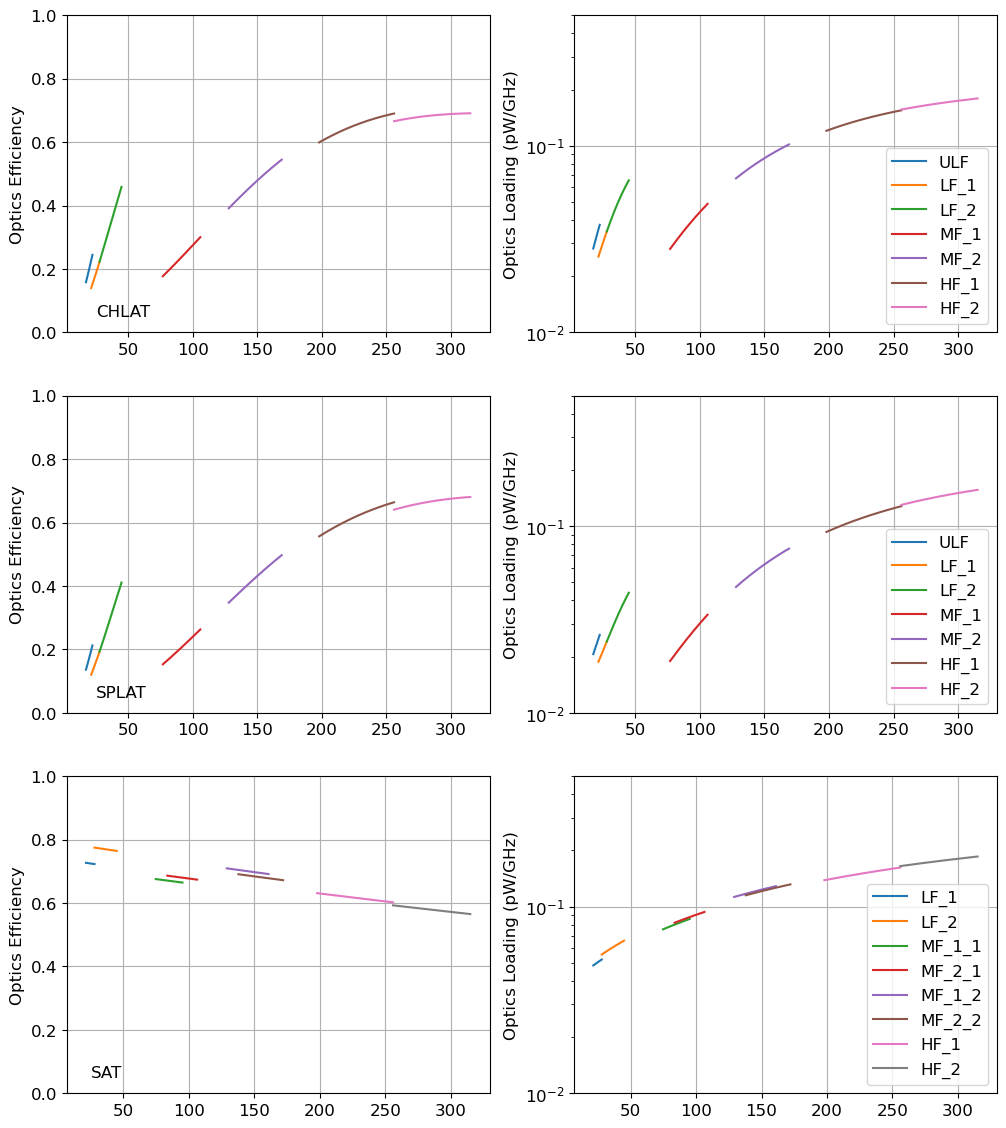

In [11]:
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.figsize'] = [12,14]

nn = 1  # index for left hand plot
mm = 2  # index for right hand plot

print('Flat band-average optics efficiency (0 to 1) and detector loading (pW/GHz)')
for tel in indata.keys():
    print('----------------')
    print(tel.ljust(6),'    Effic  Loading')
    for ch in sims[tel]['channels'].keys():
        #
        plt.subplot(3,2,nn)
        nuvec = sims[tel]['outputs'][ch]['nu']
        optics_effic = sims[tel]['outputs'][ch]['optics_effic_total']
        optics_loading = 1e21*sims[tel]['outputs'][ch]['optics_Pnu_total']
        plt.plot(nuvec,optics_effic,label=ch)
        #
        plt.subplot(3,2,mm)
        plt.semilogy(nuvec,optics_loading,label=ch)
        
        print('  {0:6s}:  {1:4.3f}  {2:4.3f}'.format(ch,np.mean(optics_effic),np.mean(optics_loading)))
        
    
    plt.subplot(3,2,nn)
    plt.ylim(0,1.0)
    plt.ylabel('Optics Efficiency')
    plt.text(25,0.05,tel)
    #plt.legend()
    plt.grid()
    
    plt.subplot(3,2,mm)
    plt.ylim(0.01,0.5)
    plt.ylabel('Optics Loading (pW/GHz)')
    plt.legend(loc='lower right')
    plt.grid()
    
    nn = nn+2
    mm = mm+2

In [12]:
sims['CHLAT']['outputs']['LF_1']['optics_effic_total']

array([0.13973885, 0.13985702, 0.13997522, 0.14009346, 0.14021173,
       0.14033003, 0.14044837, 0.14056675, 0.14068516, 0.1408036 ,
       0.14092208, 0.14104059, 0.14115913, 0.14127771, 0.14139633,
       0.14151498, 0.14163366, 0.14175238, 0.14187113, 0.14198991,
       0.14210873, 0.14222758, 0.14234647, 0.14246539, 0.14258434,
       0.14270333, 0.14282236, 0.14294141, 0.1430605 , 0.14317963,
       0.14329878, 0.14341797, 0.1435372 , 0.14365646, 0.14377575,
       0.14389508, 0.14401444, 0.14413383, 0.14425326, 0.14437272,
       0.14449221, 0.14461174, 0.1447313 , 0.1448509 , 0.14497053,
       0.14509019, 0.14520988, 0.14532961, 0.14544937, 0.14556917,
       0.14568899, 0.14580886, 0.14592875, 0.14604868, 0.14616864,
       0.14628863, 0.14640866, 0.14652872, 0.14664882, 0.14676894,
       0.1468891 , 0.1470093 , 0.14712952, 0.14724978, 0.14737007,
       0.1474904 , 0.14761075, 0.14773114, 0.14785157, 0.14797202,
       0.14809251, 0.14821303, 0.14833359, 0.14845418, 0.14857

# Print optical powers and efficiencies for each element, for each channel.

In [13]:
import jbolo_funcs as jbf

for tel in indata.keys():
    print(tel,'--------------------------')
    for ch in sims[tel]['channels'].keys():
        jbf.print_optics(sims[tel],ch)
        print('....')

    

CHLAT --------------------------
ULF
Element            Popt(pW)   Effic  Effic_cumul
detector       :    0.0000     0.6500    1.0000
Lens_3         :    0.0000     0.9933    0.6500
lyot           :    0.0235     0.2353    0.6456
lowpass        :    0.0001     0.9400    0.1519
Lens_2         :    0.0000     0.9933    0.1428
Lens_1         :    0.0000     0.9933    0.1418
nylon_filt     :    0.0000     0.9899    0.1409
alumina_filt   :    0.0019     0.9761    0.1395
RTMLI_10       :    0.0056     0.9960    0.1361
window         :    0.0023     0.9891    0.1356
secondary      :    0.0617     0.9755    0.1341
primary        :    0.0111     0.9955    0.1308
atmosphere     :    0.0316     0.9867    0.1302
cmb            :    0.0201     0.0000    0.1284
P_opticsonly_total = 1.0620e-13
P_optical_total =  1.5792e-13
....
LF_1
Element            Popt(pW)   Effic  Effic_cumul
detector       :    0.0000     0.6500    1.0000
Lens_3         :    0.0001     0.9931    0.6500
lyot           :    0.027